In [1]:
import os
os.chdir('/Users/xinglongli/git_local/sts-jax')

# Structural time series (STS) model with Poisson likelihood

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np

import sts_jax.structural_time_series.sts_model as sts

## Synthetic Data

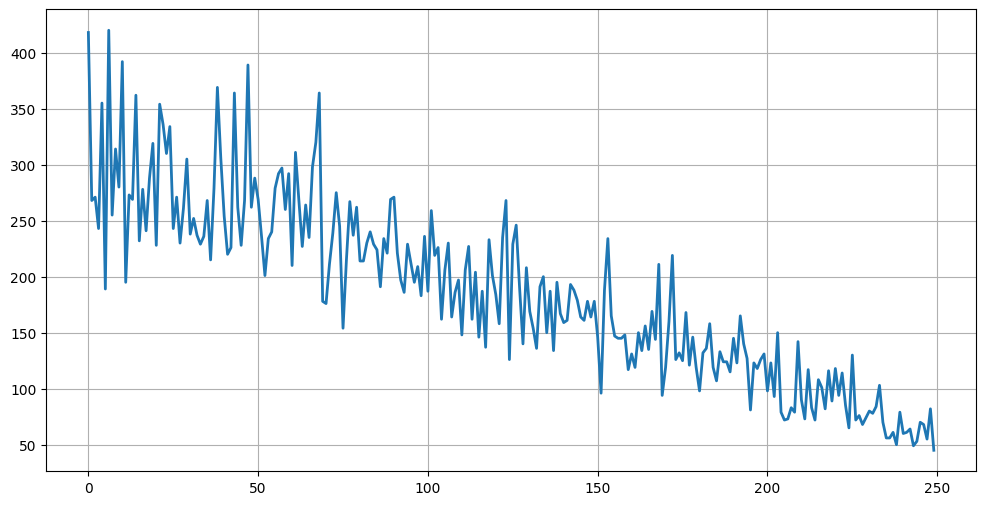

In [3]:
num_steps = 300
num_training_steps = 250
num_forecast_steps = num_steps - num_training_steps

np.random.seed(1)
counts = np.round(3 + np.random.lognormal(np.log(np.linspace(
    num_steps, 5, num=num_steps)), 0.2, size=num_steps))
counts = counts.astype(np.float32)
counts_training = counts[:num_training_steps]
plt.figure(figsize=(12, 6))
plt.plot(counts_training, lw=2)
plt.grid()

## Implementation via CMGF

In [4]:
counts = jnp.array(counts[:num_steps, None])
counts_training = counts[:num_training_steps]
counts_predict = counts[-num_forecast_steps:]

### Build the STS model

In [6]:
trend = sts.LocalLinearTrend()
model = sts.StructuralTimeSeries([trend],
                                 obs_distribution='Poisson',
                                 obs_time_series=counts_training)

### Model fitting

In [7]:
# Fit the model using HMC
obs_time_series = counts_training
key = jr.PRNGKey(0)

In [8]:
parameter_samples = model.fit_mle(obs_time_series)

TypeError: <lambda>() takes 1 positional argument but 2 were given

### Forecast

/home/xinglong/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/home/xinglong/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:1806: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "array")
/home/xinglong/.local/lib/python3.8/site-packages/jax/_src/numpy/lax

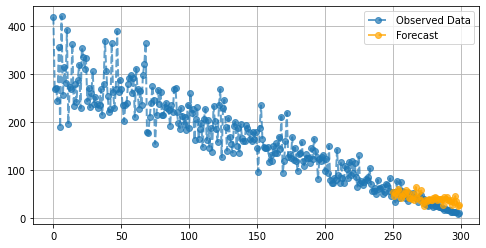

In [22]:
forecasts = model.forecast(jr.PRNGKey(0), observed_time_series, parameter_samples, num_timesteps_forecast)
forecast_means = jnp.median(jnp.squeeze(forecasts['means']), axis=0)
CI = 90
CI_interval = jnp.array([(100 - CI)/2, 100 - (100 - CI)/2])
lower, upper = jnp.percentile(jnp.squeeze(forecasts['means']), CI_interval, axis=0)
forecast_scale = jnp.std(jnp.squeeze(forecasts['means']), axis=0)

# Plot the prediction
time_steps = jnp.arange(num_timesteps)
time_steps_forecast = time_steps[-num_timesteps_forecast:]

fig = plt.figure(figsize=(8, 4))
plt.plot(time_steps, observed_counts, lw=2, linestyle='--', marker='o',
         alpha=0.7, label='Observed Data')
plt.plot(time_steps_forecast, forecast_means, lw=2, linestyle='--', marker='o',
         color='orange', alpha=0.7, label='Forecast')
plt.fill_between(time_steps_forecast, lower, upper, color='orange', alpha=0.3)
# plt.fill_between(time_steps_forecast, forecast_means-2*forecast_scale, forecast_means+2*forecast_scale, color='orange', alpha=0.3)
plt.grid()
plt.legend()